generator逻辑
* 数据增广
* 利用2张subimage和GT计算所有初始化anchor，34125个anchor/图
* 分类正负选取
* 分类和回归的target计算

## imports

In [20]:
import sys
sys.path.append('/opt/code/face/dual_shot')
sys.path.append('/opt/code/face/dual_shot/prepare_data')
from dual_conf import current_config as conf
from widerface import WIDERFaceDetection,WIDERFaceAnnotationTransform
import os 
import numpy as np

In [21]:
batch_size=2
net_in_size = 640


In [22]:
testset = WIDERFaceDetection(conf.data_path, 'train' , None, WIDERFaceAnnotationTransform())
print('num_image:',len(testset))

Error bbox number to filter : 48,  bbox number: 159376
num_image: 12876


## 可视化

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_anchor(img_array,anchor_list):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img_array)
    for a in anchor_list:
        x1,y1,x2,y2 = [int(i) for i in a]
        rect = patches.Rectangle((x1, y1),x2-x1, y2-y1,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

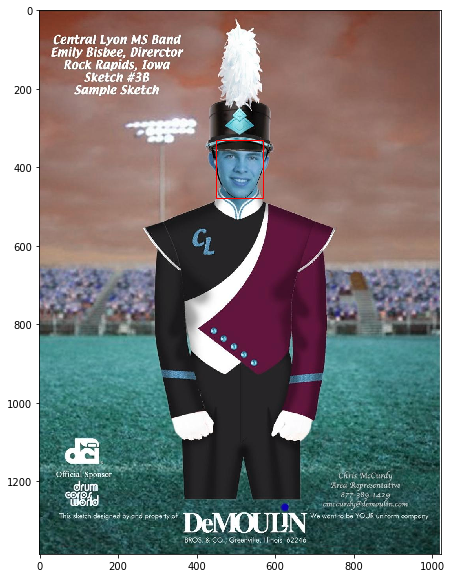

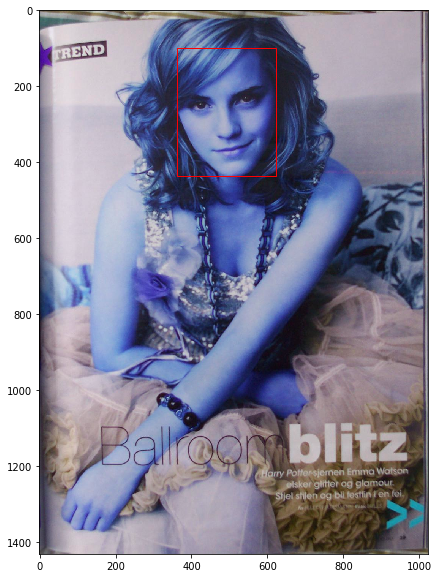

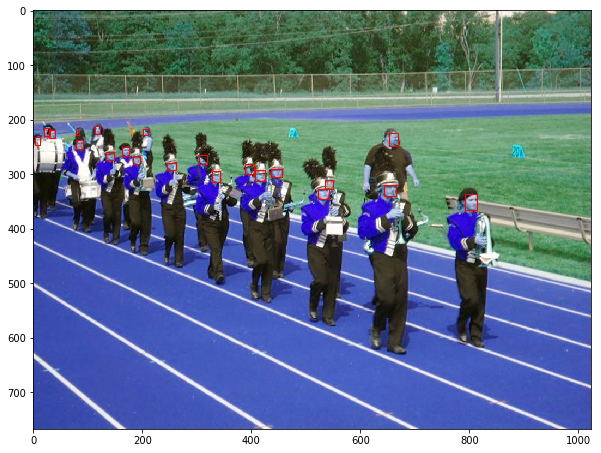

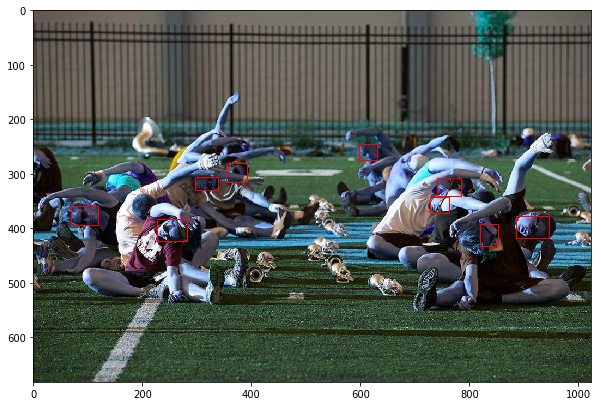

In [24]:
for i in range(0,4):
    image = testset.pull_image(i)
    img_id, annotation = testset.pull_anno(i)
    plot_anchor(image,annotation)


## 数据增广
思路：
* 从每张图中随机选取一个人脸，计算人脸的w,h,center
* anchor_scale从（16，32，64，128，512）中随机取值rand_scale，rand_scale/640就是人脸大小和裁剪区域大小的ratio
* 通过人脸w,h,center和人脸大小和裁剪区域大小的ratio，计算可得裁剪区域
* 裁剪subimage，并调整gt坐标
* 忽略没有在subimage里的gt，忽略在subimage里但<20个像素的gt
* subimage resize到640 * 640，并调整gt坐标

In [25]:
import random
anchor_scale = [16,32,56,128,512]

In [26]:
rand_scale = random.choice(anchor_scale)
face_ratio = rand_scale/ net_in_size
face_ratio

0.0875

In [55]:
from PIL import Image
for i in range(0,3):
    image = testset.pull_image(i)
    _, gts = testset.pull_anno(i)
    gts= np.array(gts)

    rand_ind = np.random.randint(0,len(gts),1)[0]
    gt = gts[rand_ind]
    w_gt =gt[2]-gt[0] 
    h_gt = gt[3]-gt[1]
    x_c = w_gt / 2 + gt[0]
    y_c = h_gt / 2 + gt[1]
    
    face_size = np.sqrt(w_gt*h_gt)
    sub_size = face_size/face_ratio
    sub_half = sub_size/2
    sub_x1,sub_x2 = x_c-sub_half,x_c+sub_half
    sub_y1,sub_y2 = y_c-sub_half,y_c+sub_half
    print(image.shape)
    print(sub_x1, sub_y1, sub_x2, sub_y2)
    pil_img = Image.fromarray(image)
    sub_img = np.array(pil_img.crop((sub_x1, sub_y1, sub_x2, sub_y2)))
    print(sub_img.shape)
    sub_x1, sub_y1, sub_x2, sub_y2 = [0 if i < 0 else int(i) for i in [sub_x1, sub_y1, sub_x2, sub_y2]]
    print(sub_x1, sub_y1, sub_x2, sub_y2)
    sub_img = image[sub_y1:sub_y2,sub_x1:sub_x2,  :]
    
    print(sub_img.shape)


    

(1385, 1024, 3)
-255.19014666606188 -360.6901466660619 1274.190146666062 1168.690146666062
(1530, 1529, 3)
0 0 1274 1168
(1168, 1024, 3)
(1432, 1024, 3)
-1208.4777239928546 -1433.4777239928546 2192.4777239928544 1967.4777239928546
(3400, 3400, 3)
0 0 2192 1967
(1432, 1024, 3)
(768, 1024, 3)
549.0233260441976 124.02332604419757 772.9766739558024 347.9766739558024
(224, 224, 3)
549 124 772 347
(223, 223, 3)


In [28]:
# transfer gt coordinates to fit the cropped image
x_crop= gts[:,[0,2]]-sub_x1
y_crop= gts[:,[1,3]]-sub_y1
gt_crop = np.column_stack([x_crop[:,0],y_crop[:,0],x_crop[:,1],y_crop[:,1]])
gt_crop = gt_crop.astype('int')

# remove gt in corpped image which is less than 20 pixel
gt_crop[gt_crop < 0] = 0
gt_crop[gt_crop > sub_size] = sub_size
gt_area = [(i[2] - i[0]) * (i[3] - i[1]) for i in gt_crop]
big_gt_ind = [i for i, j in enumerate(gt_area) if j > 20]
gt_in_crop = gt_crop[big_gt_ind]
    
# resize to 640*640
import cv2
sub_img = cv2.resize(sub_img,dsize=(net_in_size,net_in_size),interpolation=cv2.INTER_LINEAR)  # dsize(cols,rows)

In [29]:
# get the GT box coordinates, and resize to account for image resizing
import numpy as np
def adjust_gt(bboxes,width,height,resized_width,resized_height):
    num_bboxes = bboxes.shape[0]
    gta = np.zeros((num_bboxes, 4),dtype='int')
    for bbox_num, bbox in enumerate(bboxes):
        gta[bbox_num, 0] = bbox[0] * (resized_width / float(width))
        gta[bbox_num, 1] = bbox[1] * (resized_width / float(width))
        gta[bbox_num, 2] = bbox[2] * (resized_height / float(height))
        gta[bbox_num, 3] = bbox[3] * (resized_height / float(height))
    return gta

In [30]:
gt_in_crop = adjust_gt(gt_in_crop,sub_size,sub_size,net_in_size,net_in_size)

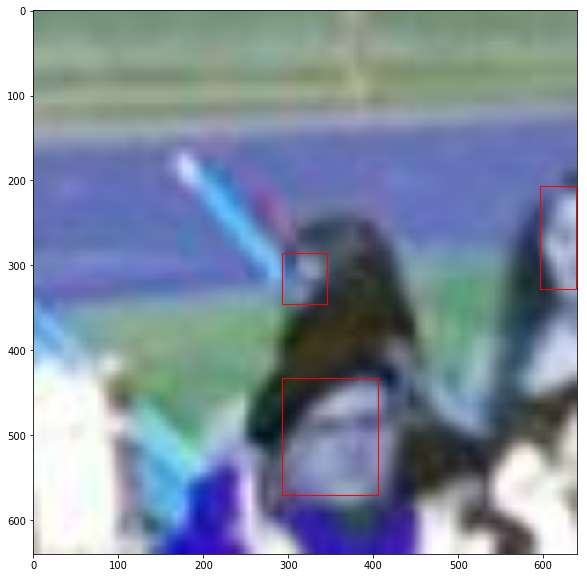

In [31]:
 plot_anchor(sub_img,gt_in_crop)

In [13]:
import random
from PIL import Image
import cv2
import numpy as np

# get the GT box coordinates, and resize to account for image resizing
def adjust_gt(bboxes,width,height,resized_width,resized_height):
    num_bboxes = bboxes.shape[0]
    gta = np.zeros((num_bboxes, 4),dtype='int')
    for bbox_num, bbox in enumerate(bboxes):
        gta[bbox_num, 0] = bbox[0] * (resized_width / float(width))
        gta[bbox_num, 1] = bbox[1] * (resized_width / float(width))
        gta[bbox_num, 2] = bbox[2] * (resized_height / float(height))
        gta[bbox_num, 3] = bbox[3] * (resized_height / float(height))
    return gta

def aug(image,gts):
    anchor_scale = [16,32,56,128,512]
    rand_scale = random.choice(anchor_scale)
    face_ratio = rand_scale/ net_in_size


    # randomly select a gt
    rand_ind = np.random.randint(0,len(gts),1)[0]
    gt = gts[rand_ind]
    w_gt =gt[2]-gt[0] 
    h_gt = gt[3]-gt[1]
    x_c = w_gt / 2 + gt[0]
    y_c = h_gt / 2 + gt[1]

    # calculate sub_image area and crop it 
    face_size = np.sqrt(w_gt*h_gt)
    sub_size = face_size/face_ratio
    sub_half = sub_size/2
    sub_x1,sub_x2 = x_c-sub_half,x_c+sub_half
    sub_y1,sub_y2 = y_c-sub_half,y_c+sub_half
    pil_img = Image.fromarray(image)
    sub_img = np.array(pil_img.crop((sub_x1, sub_y1, sub_x2, sub_y2)))

    # transfer gt coordinates to fit the cropped image
    x_crop= gts[:,[0,2]]-sub_x1
    y_crop= gts[:,[1,3]]-sub_y1
    gt_crop = np.column_stack([x_crop[:,0],y_crop[:,0],x_crop[:,1],y_crop[:,1]])
    gt_crop = gt_crop.astype('int')
    
    # remove gt in corpped image which is less than 20 pixel
    gt_crop[gt_crop < 0] = 0
    gt_crop[gt_crop > sub_size] = sub_size
    gt_area = [(i[2] - i[0]) * (i[3] - i[1]) for i in gt_crop]
    big_gt_ind = [i for i, j in enumerate(gt_area) if j > 20]
    gt_in_crop = gt_crop[big_gt_ind]
    
    # resize to 640*640
    sub_img = cv2.resize(sub_img,dsize=(net_in_size,net_in_size),interpolation=cv2.INTER_LINEAR)  # dsize(cols,rows)
    gt_in_crop = adjust_gt(gt_in_crop,sub_size,sub_size,net_in_size,net_in_size)
    return sub_img,gt_in_crop

## 多张图片数据增广

In [14]:
testset = WIDERFaceDetection(conf.data_path, 'train' , None, WIDERFaceAnnotationTransform())
index_list = np.random.randint(0,len(testset),batch_size)
print(index_list)

Error bbox number to filter : 48,  bbox number: 159376
[9725 2211]


In [15]:
batch_img = []
batch_gt = []
for index in index_list:
    print(index)
    image = testset.pull_image(index)
    _, gts = testset.pull_anno(index)
    gts= np.array(gts)
    sub_img,gt_in_crop = aug(image,gts)
    print(len(gt_in_crop))
    batch_img.append(sub_img)
    batch_gt.append(gt_in_crop)

9725
2
2211
1


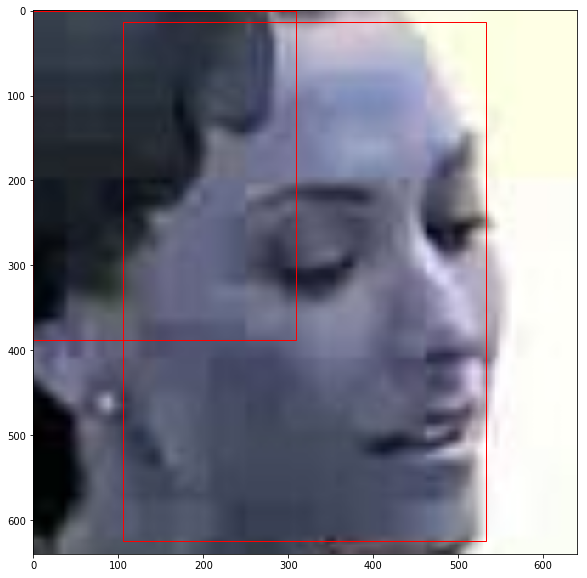

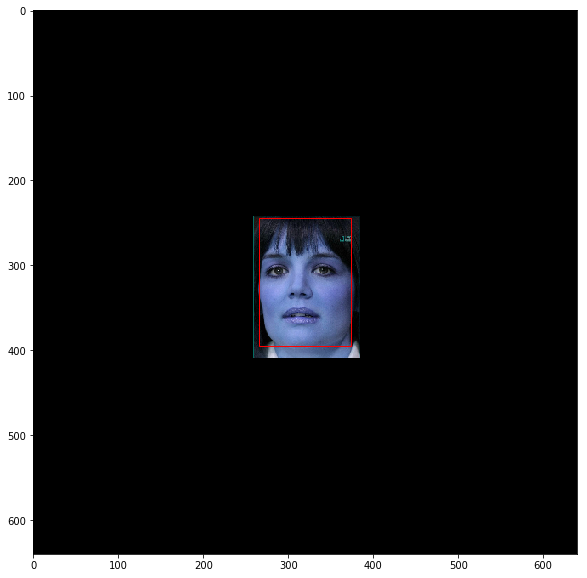

In [16]:
for i in range(batch_size):
    plot_anchor(batch_img[i],batch_gt[i])

### func

In [17]:
from qugment import aug_single_image

In [18]:
def gen_data():
    test_set = WIDERFaceDetection(conf.data_path, 'train', None, WIDERFaceAnnotationTransform())
    while True:
        index_list = np.random.randint(0, len(test_set), conf.batch_size)
        batch_img = []
        batch_gt = []
        for index in index_list:
            print(index)
            image = test_set.pull_image(index)
            _, gts = test_set.pull_anno(index)
            gts = np.array(gts)
            sub_img, gt_in_crop = aug_single_image(image, gts)
            print(len(gt_in_crop))
            batch_img.append(sub_img)
            batch_gt.append(gt_in_crop)

        yield batch_img, batch_gt

Error bbox number to filter : 48,  bbox number: 159376
12230
1
5220
1


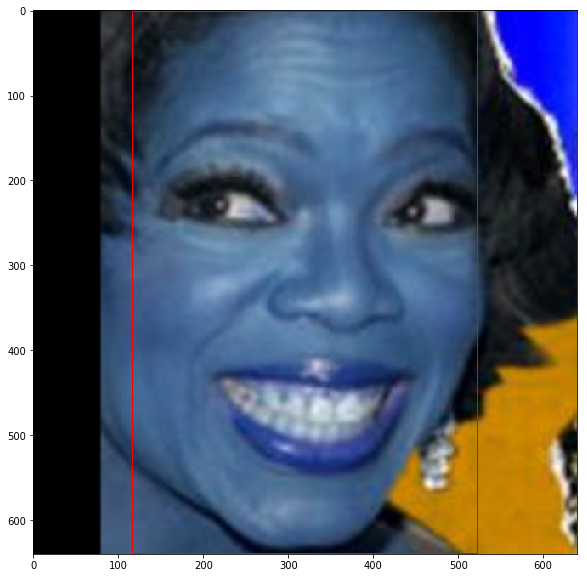

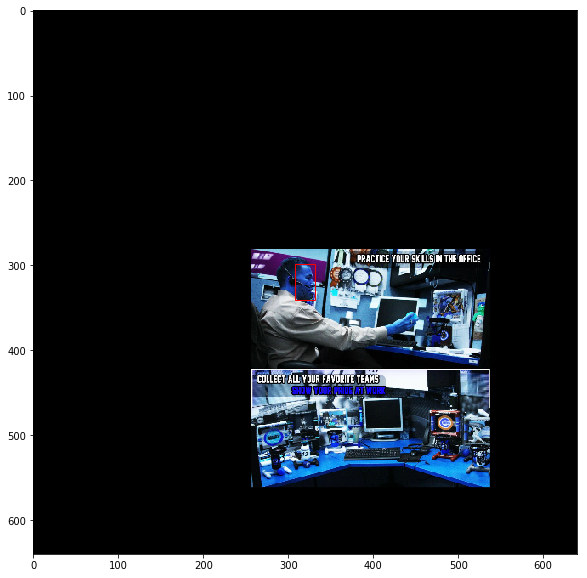

In [19]:
gen = gen_data()
batch_img, batch_gt = next(gen)
for i in range(batch_size):
    plot_anchor(batch_img[i],batch_gt[i])